In [63]:
import random, math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import numpy as np

from matplotlib import style
style.use('seaborn')

In [64]:
random.seed(42)

In [65]:
def exprand(lambdr):
    return -math.log(1.0 - random.random()) / lambdr

print(exprand(1/5))
print(np.random.exponential(5))

5.1003014363740045
3.0370997597118037


In [66]:
a = []
b = []
for i in range(100000):
    a.append(np.random.exponential(5))
    b.append(exprand(1/5))
print(statistics.mean(a))
print(statistics.mean(b))

4.962475468684598
5.0074373915680574


In [67]:
def exprand(lambdr):
    return -math.log(1.0 - random.random()) / lambdr

class Customer:
    def __init__(self, customer_id, y, time_to_process_this_customer):
        self.customer_id = customer_id  # номер человека
        self.y = y # время, через которое он придет
        self.check_in_time = 0 #время, в которое он придет
        if time_to_process_this_customer < 1:
            self.time_to_process_this_customer = 1
        else:
            self.time_to_process_this_customer = round(time_to_process_this_customer) # время на обработку этого человека (+1 временное решение того, что 0 требуется на процесс)


# Обработчик
class Handler:
    def __init__(self, id):
        self.customer = None
        self.id = id

    def process_customer(self):
        if (self.customer is not None):
            #print("Id of handler:"+str(self.id))
            self.customer.time_to_process_this_customer -= 1
            #print("Time left:" + str(self.customer.time_to_process_this_customer))
            if (self.customer.time_to_process_this_customer < 1):
                self.customer = None
                #print("Processed!")

In [69]:
# Вeликий обрабатор!
class MainHandler:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        #self.number_of_customers = number_of_customers
        self.list_of_customers = []
        self.list_of_handlers = []
        self.number_of_customers_left  = 0
        self.customers_growth = []
        self.customers_all = 0
        self.mean_time_spent = []
        self.handler_load = []
        self.lambda_ = lambda_
        self.nu = nu
        
    def get_next(self, customer_id, lambd,nu):
        # Устанавливаем номер человека
        # время, через котрое он придет
        # и время, которое требуется на его обработку
        customer = Customer(customer_id, exprand(1/lambd), exprand(1/nu))
    
        return customer
    
    def generate_customers(self, steps):
        lost_time = steps  # оставшееся количество шагов == время для генерации

        customer_id = 0
        while (lost_time > 0):
            customer_id += 1
            customer = self.get_next(customer_id, self.lambda_, self.nu)
            lost_time -= customer.y
            customer.check_in_time = round(steps - lost_time)
            self.list_of_customers.append(customer)

        #print("Number of customers:" + str(len(self.list_of_customers)))
        #for customer in self.list_of_customers:
            #print("check_in_time: "+str(customer.check_in_time) + " and time_to_process_this_customer:" + str(customer.time_to_process_this_customer))

    def start(self, steps):
        self.generate_customers(steps)
        
        for i in range(self.number_of_handlers):
            self.list_of_handlers.append(Handler(i))

        for i in range(steps):
            #print("\nSTEP" + str(i))
            # достаем людей, которые пришли в данную секунду
            new_customers = [customer for customer in self.list_of_customers if customer.check_in_time == i]
            #print("New customers in current time: " + str(len(new_customers))) 
            
            # save customers number
            self.customers_all += len(new_customers)
            self.customers_growth.append(self.customers_all)

            # если есть пустые кассы, то пихаем туда человека
            for new_customer in new_customers:
                is_wait = True
                for handler in self.list_of_handlers:
                    if handler.customer is None:
                        self.mean_time_spent.append(new_customer.time_to_process_this_customer) # верно?
                        #print("New customer, time to process: " + str(new_customer.time_to_process_this_customer))
                        handler.customer = new_customer
                        is_wait = False
                        break

                # иначе счетчик ушедших++
                if (is_wait):
                    #print("Customer left!")
                    self.number_of_customers_left += 1  
            
            # обрабатываем людей
            for handler in self.list_of_handlers:
                handler.process_customer()
        
            number_of_working_handlers = 0
            for handler in self.list_of_handlers:
                if handler.customer is not None:
                    number_of_working_handlers += 1
            
            self.handler_load.append(number_of_working_handlers)
            # продолжаем

    # statistics
    def get_customers(self):
        return self.list_of_customers
    
    # количество пришедших кастомеров с начала
    def get_customer_growth(self):
        return self.customers_growth
    
    # Среднее количество НОВЫХ заявок в системе
    def get_mean_customer_growth(self):
        return self.customers_all/len(self.customers_growth)
    
    # количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_handler_load(self):
        return self.handler_load
    
    # Среднее количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_mean_handler_load(self):
        sum_load = 0
        for load in self.handler_load:
            sum_load += load
        
        return sum_load/len(self.handler_load)
    
    # среднее время пребыания?
    def get_mean_time_spent(self):
        return statistics.mean(self.mean_time_spent)
    
    # вероятность отказа
    def get_deny_probability(self):
        return self.number_of_customers_left/self.customers_all

In [70]:
class Model:
    def __init__(self, lambda_, nu, number_of_handlers):
        self.__handler = MainHandler(number_of_handlers, lambda_, nu)
        self.__time = None
        
    def run(self):
        if self.__time is None or self.__handler is None:
            raise ValueError
        
        self.__handler.start(self.__time)
        
    def set_time(self, time):
        if time <= 0:
            raise ValueError
            
        self.__time = time
        
    def get_time(self):
        return self.__time
    
    def get_handler(self):
        return self.__handler
    
    def set_handler(self, handler):
        self.__handler = handler
    
    handler = property(get_handler, set_handler)
    time = property(get_time, set_time)


In [71]:
# Устанавливаем параметры
'''lambda_ = 1 # интенсивность
nu = 5 #пропускная способность
number_of_handlers = 5 # кол-во обработчиков
random.seed(42)

NUMBER_OF_STEPS = 50*10 # общее количество шагов == времени'''




'lambda_ = 1 # интенсивность\nnu = 5 #пропускная способность\nnumber_of_handlers = 5 # кол-во обработчиков\nrandom.seed(42)\n\nNUMBER_OF_STEPS = 50*10 # общее количество шагов == времени'

In [72]:
model = Model(1, 5, 5)

In [73]:
#main = MainHandler(number_of_handlers, lambda_, nu)
#main.start(NUMBER_OF_STEPS)

model.time = 500
model.run()

In [74]:
print(model.handler.get_mean_time_spent())

4.464824120603015


In [75]:
print(model.handler.number_of_customers_left)
print(model.handler.customers_all)

116
514


In [76]:
print(model.handler.get_deny_probability())

0.22568093385214008


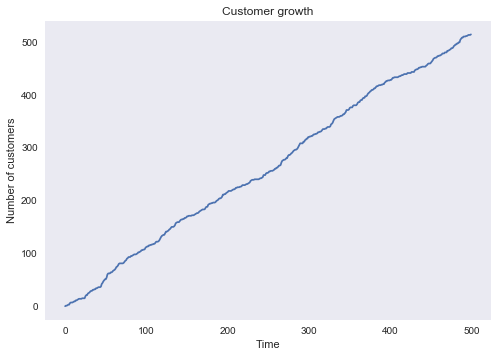

In [77]:
import matplotlib

customers = model.handler.get_customer_growth()

# Data for plotting
x = customers

fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Number of customers',
       title='Customer growth')
ax.grid()

# fig.savefig("Customer_growth.png")
plt.show()

In [78]:
print(model.handler.get_mean_customer_growth())

1.028


In [79]:
print(model.handler.get_mean_handler_load())

2.758


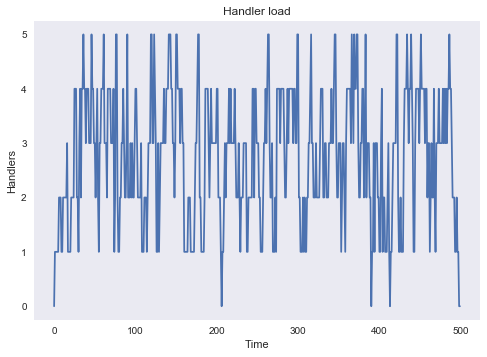

In [83]:
import matplotlib

load = model.handler.get_handler_load()

# Data for plotting
x = load


fig, ax = plt.subplots()

ax.plot(x)

ax.set(xlabel='Time', ylabel='Handlers',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

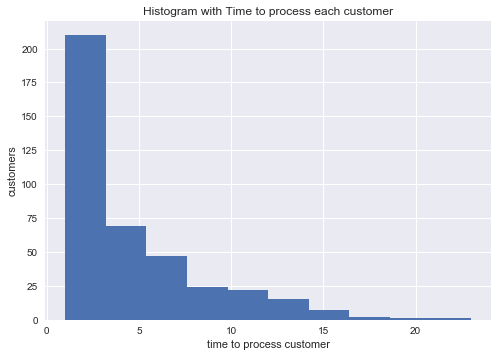

In [84]:
x = model.handler.mean_time_spent

# the histogram of the data
n, bins, patches = plt.hist(x)


plt.xlabel('time to process customer')
plt.ylabel('customers')
plt.title('Histogram with Time to process each customer')

plt.grid(True)
plt.show()

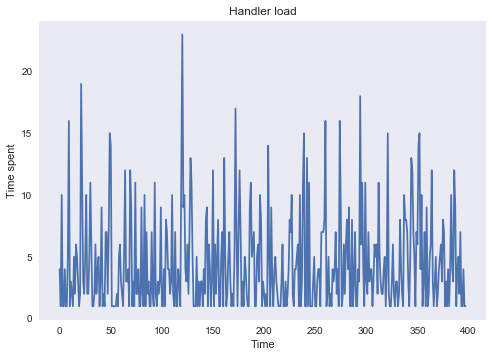

In [85]:
import matplotlib

load = model.handler.mean_time_spent

# Data for plotting
x = load


fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Time spent',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

In [1]:
class Theory:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        self.lambda_ = lambda_
        self.nu = nu

# вероятность, что k обработчиков заняты
    def get_k_handlers_load_probability(self, k):
        traffic=self.lambda_/self.nu
        return (pow(traffic, k)/math.factorial(k))/(sum(pow(traffic,n)/math.factorial(n) for n in range(0, self.number_of_handlers)))

# вероятность отказа
    def get_loss_probability(self):
        return self.get_k_handlers_load_probability(self.number_of_handlers)

# относительная пропускная способность - вероятность, что заявка будет обслужена
    def get_handle_probability(self):
        return 1 - self.get_loss_probability()

# среднее время поступления заявки
    def get_mean_waiting_time(self):
        return self.lambda_

# среднее время обслуживания
    def get_mean_time_spent(self):
        return 1 / self.nu

# абсолютная пропускная способность - среднее число заявок, обслуживаемых в единицу времени
    def absolute_bandwidth(self):
        return self.lambda_ * self.get_handle_probability()

# число покупалетей за все время
    def get_customers_all(self, steps):
        return self.lambda_ * steps

# среднее число занятых касс - интенсивность потока обслуженных системой заявок (в единицу времени)
    def get_mean_handler_load(self):
        return (sum(n * self.get_k_handlers_load_probability(n) for n in range(0, self.number_of_handlers)))
#        return absolute_bandwidth() / self.nu

    def get_number_of_customers_left(self, steps):
        return self.get_customers_all(steps) * self.get_loss_probability()